## Inverse transformation(alignment) on face
使用 PCA 對 landmarks 降維，再 sample 出新的臉座標並還原

缺點：只使用統計值，沒有用臉的特徵去決定要怎麼轉臉
* resampling on face bbox coords. & facial landmarks
* Using same algorithm of alignment to get quad.
* perform inverse transformation on that

In [1]:
import pickle
import json
from random import sample
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
from sklearn.decomposition import PCA

In [2]:
!ls kp_heatmaps/keypoints/train | wc -l

22204


In [3]:
!ls AB_RGBA/train | wc -l

22204


In [19]:
KP_THRES = 0.05
NUM_DIM = 5
OUTPUT_SIZE = 256
ENABLE_PADDING = True
IMG_SIZE = (256, 256)

In [5]:
TRAIN_IMG_PATHS = sorted(list(Path('AB_RGBA/train').glob('*.png')))
KP_FILES = {p.stem: p for p in Path('kp_heatmaps/keypoints/train/').glob('*.pkl')}

DLIB_OUTPUTS = json.load(open('../deepfashion_landmarks.json', 'r'))
to_keep = [p.stem for p in TRAIN_IMG_PATHS]
LANDMARKS = {Path(item['in_the_wild']['file_path']).stem: np.array(item['in_the_wild']['face_landmarks']) 
             for item in DLIB_OUTPUTS.values() if Path(item['in_the_wild']['file_path']).stem in to_keep}
BOXES = {Path(item['in_the_wild']['file_path']).stem: np.array(item['in_the_wild']['box']) 
             for item in DLIB_OUTPUTS.values() if Path(item['in_the_wild']['file_path']).stem in to_keep}

print(f"img: {len(TRAIN_IMG_PATHS)}, Keypoins: {len(KP_FILES)}, landmarks: {len(LANDMARKS)}")

img: 22204, Keypoins: 22204, landmarks: 22204


In [6]:
set(list(KP_FILES.keys())) == set([p.stem for p in TRAIN_IMG_PATHS]) and set([p.stem for p in TRAIN_IMG_PATHS]) == set(list(LANDMARKS.keys()))

True

### Fake Images from StyleGAN2-ada

In [7]:
fake_img_paths = list(Path('/home/u3534611/data/stylgan2-ada-outputs/').glob('*.png'))
print("total: ", len(fake_img_paths))

total:  50001


## Helper Function

In [8]:
def draw_point(imgd, point, r=3, color="#ff0000"):
    point = point.astype(int)
    imgd.ellipse([*(point - r), *(point + r)], fill=color)
    
def draw_quad(imgd, quad, color="#ff0000"):
    display_quad = np.where(quad < 0, 0, quad).astype(int)
    print(display_quad)
    for idx in reversed(range(display_quad.shape[0])):
        imgd.line([*display_quad[idx], *display_quad[idx - 1]], fill=color)

def gallery(imgs):
    if isinstance(imgs, list):
        imgs = np.array(imgs)
    
    b, h, w, c = imgs.shape
    return imgs.transpose(1, 0, 2, 3).reshape(h, b*w, c)

## Landmarks

In [31]:
observations = []
headers = ['box_x1', 'box_y1', 'box_x2', 'box_y2', 'crop_x1', 'crop_y1', 'crop_x2', 'crop_y2',
             'quad_x1', 'quad_y1', 'quad_x2', 'quad_y2', 'quad_x3', 'quad_y3', 'quad_x4', 'quad_y4']
for p in TRAIN_IMG_PATHS: #sample(TRAIN_IMG_PATHS, 5):
    x1, y1, w, h = BOXES[p.stem]
    x2, y2 = x1 + w, y1 + h
    observation = [x1/4, y1/4, x2/4, y2/4]
    
    lm = np.array(LANDMARKS[p.stem])
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2
    
    # shrink = int(np.floor(qsize / OUTPUT_SIZE * 0.5))
    # print("shrink: ", shrink)
    # if shrink > 1:
    #     rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
    #     img = img.resize(rsize, PIL.Image.ANTIALIAS)
    #     quad /= shrink
    #     qsize /= shrink
    
    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0) / 4., max(crop[1] - border, 0) / 4., min(crop[2] + border, IMG_SIZE[0]) / 4., min(crop[3] + border, IMG_SIZE[1]) / 4.)

    # padding
    # pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    # pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    # print("pad: ", pad)
    # if ENABLE_PADDING and max(pad) > border - 4:
    #     pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    #     img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    #     h, w, _ = img.shape
    #     y, x, _ = np.ogrid[:h, :w, :1]
    #     mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
    #     blur = qsize * 0.02
    #     img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    #     img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
    #     img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
    #     quad += pad[:2]
#     print(f"crop: {crop}, quad: {quad}")
    
    observation.extend(crop)
    observation.extend(quad.flatten() / 4)
    observations.append(observation)
    
observations = pd.DataFrame(observations, columns=headers)
observations

,box_x1,box_y1,box_x2,box_y2,crop_x1,crop_y1,crop_x2,crop_y2,quad_x1,quad_y1,quad_x2,quad_y2,quad_x3,quad_y3,quad_x4,quad_y4
0,118.50,14.00,140.75,36.50,105.00,0.00,64.0,44.75,108.962333,3.588691,111.351191,40.762667,148.525167,38.373809,146.136309,1.199833
1,106.25,16.75,138.50,49.00,80.00,0.00,64.0,64.00,85.786305,11.326411,103.901411,66.401195,158.976195,48.286089,140.861089,-6.788695
2,85.50,20.00,112.50,46.75,62.25,0.00,64.0,64.00,68.038303,3.273537,74.023537,59.724197,130.474197,53.738963,124.488963,-2.711697
3,154.75,20.00,173.25,38.75,138.50,0.50,64.0,51.25,145.946139,4.740020,142.746270,44.022611,182.028861,47.222480,185.228730,7.939889
4,119.00,7.50,157.75,46.00,92.00,0.00,64.0,64.00,98.246365,4.952893,115.934143,63.372385,174.353635,45.684607,156.665857,-12.734885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22199,110.00,31.25,142.25,63.50,84.00,2.25,64.0,64.00,89.810443,19.702250,101.308500,77.233307,158.839557,65.735250,147.341500,8.204193
22200,118.50,16.50,140.75,39.00,106.50,1.50,64.0,47.00,110.444918,5.699087,110.730337,43.211332,148.242582,42.925913,147.957163,5.413668
22201,106.00,16.50,128.50,39.00,93.25,1.75,64.0,49.75,97.184613,7.430013,98.973763,45.959137,137.502887,44.169987,135.713737,5.640863
22202,91.50,3.75,137.75,50.25,69.25,0.00,64.0,64.00,77.183857,-10.653180,83.021820,65.403643,159.078643,59.565680,153.240680,-16.491143


## Resampling

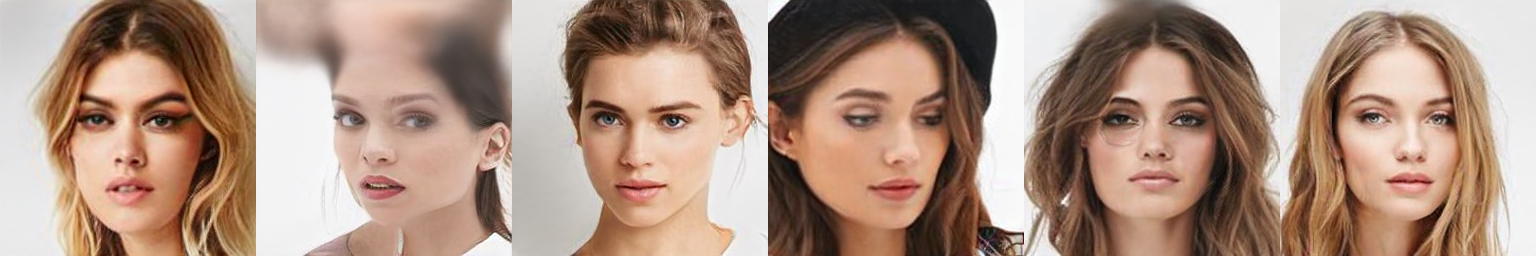

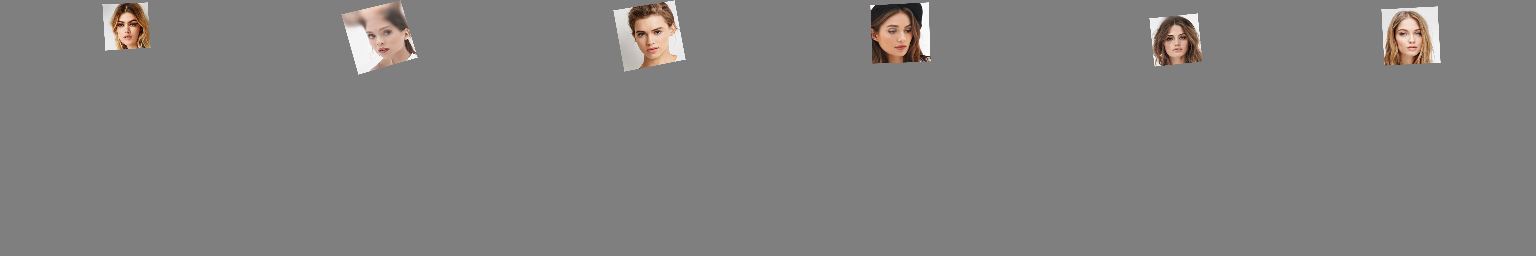

In [32]:
BS = 6
batch_data = observations.sample(BS ** 2, axis=0).to_numpy().reshape(BS, BS, -1)
resample_latents = []
for data in batch_data:
    # local mean & std
    mu, sigma = data.mean(axis=0), data.std(axis=0)
    sigma[sigma == 0.0] = 1.0
    data = (data - mu) / sigma
    
    embed = PCA(n_components=BS-1, svd_solver='full')
    embed.fit(data)
    V = embed.components_.transpose()
    V = V / np.linalg.norm(V, axis=0, keepdims=True)
    
    z = np.random.randn(NUM_DIM)
    resample_latent = z @ V.T
    resample_latents.append(resample_latent * sigma + mu)
resample_latents = np.stack(resample_latents, axis=0)

face_imgs = []
align_imgs = []
transformed_imgs = []

for resample_latent, img_p in zip(resample_latents, sample(fake_img_paths, BS)):
    resample_latent = np.where(resample_latent > 0, resample_latent, 0).astype(int)

    face_img = Image.open(img_p)
    face_imgs.append(np.array(face_img))
    face_np = np.asarray(face_img)

    # quad
    quad = resample_latent[8:].reshape(4, 2)
    for idx in reversed(range(quad.shape[0])):
        cv2.line(canvas1, tuple(quad[idx]), tuple(quad[idx -1]), (255, idx*50, 0), 4)
    
    # transformation matrix
    src = np.array([(0,0), (0,255), (255,255), (255,0)], dtype=np.float32)
    dst = quad.astype(np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    # print(M)
    trans_img = cv2.warpPerspective(face_np, M, IMG_SIZE, borderMode=cv2.BORDER_CONSTANT, borderValue=(127,127,127))
    
    transformed_imgs.append(trans_img)

display(Image.fromarray(gallery(face_imgs)).convert('RGB'))
display(Image.fromarray(gallery(transformed_imgs)).convert('RGB'))

resample_latents:  (6, 16)


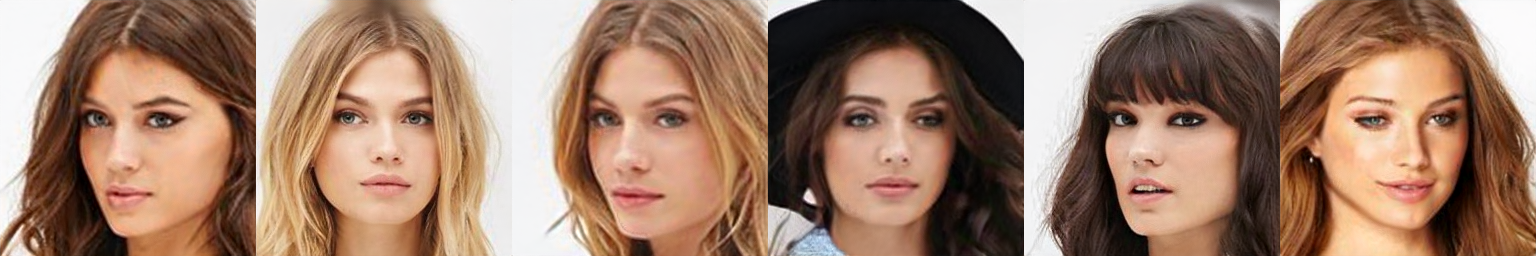

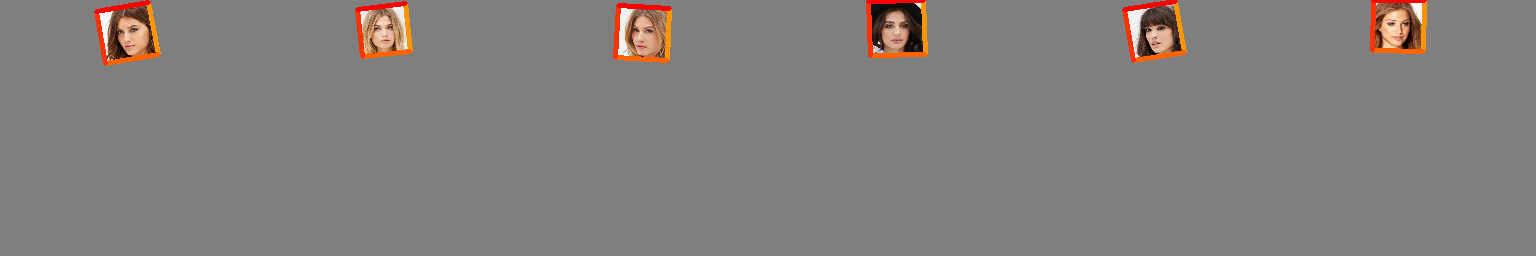

In [37]:
all_data = observations.to_numpy()
all_mu, all_sigma = all_data.mean(axis=0), all_data.std(axis=0)
all_sigma[all_sigma == 0.0] = 1.0
all_data = (all_data - all_mu) / all_sigma
all_embed = PCA(n_components=NUM_DIM, svd_solver='full')
all_embed.fit(all_data)
all_V = all_embed.components_.transpose()
all_V = all_V / np.linalg.norm(all_V, axis=0, keepdims=True)

zs = np.random.randn(BS, NUM_DIM)
resample_latents = zs @ all_V.T
resample_latents = resample_latents * all_sigma + all_mu
print("resample_latents: ", resample_latents.shape)
face_imgs = []
align_imgs = []
transformed_imgs = []

for resample_latent, img_p in zip(resample_latents, sample(fake_img_paths, BS)):
    resample_latent = np.where(resample_latent > 0, resample_latent, 0).astype(int)

    face_img = Image.open(img_p)
    face_imgs.append(np.array(face_img))
    face_np = np.asarray(face_img)

    # quad
    quad = resample_latent[8:].reshape(4, 2)
    
    # transformation matrix
    src = np.array([(0,0), (0,255), (255,255), (255,0)], dtype=np.float32)
    dst = quad.astype(np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    # print(M)
    trans_img = cv2.warpPerspective(face_np, M, IMG_SIZE, borderMode=cv2.BORDER_CONSTANT, borderValue=(127, 127, 127))
    for idx in reversed(range(quad.shape[0])):
        cv2.line(trans_img, tuple(quad[idx]), tuple(quad[idx -1]), (255, idx*50, 0), 4)    
    
    transformed_imgs.append(trans_img)

display(Image.fromarray(gallery(face_imgs)).convert('RGB'))
display(Image.fromarray(gallery(transformed_imgs)).convert('RGB'))

In [ ]:
import pickle
pickle.dump(dict(V=all_V, mu=all_mu, sigma=all_sigma, resolution=1024), open('landmarks_statistics.pkl', 'wb'))